### Wesley Janson and Drew Keller
## STAT 27420 Final Project
# Modeling Code

In [1]:
# Load in relevant packages

import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from data_utils import read_data, prep_features
import numpy as np
import matplotlib.pyplot as plt

# set random seed for numpy
RANDOM_SEED=69
np.random.seed(RANDOM_SEED)


DATA_PATH = '../paper_replication_data/new_data.csv'  # Drew's path

In [2]:
#from load_data import data, categorical_vars, cts_vars, other_vars

# loading data from online takes ~20 seconds
# to speed up, save data locally and load from there:

#data.to_csv(DATA_PATH,index=False)  # run this once

In [3]:
# Categorical_vars and cts_vars are lists of vars in each category.
# Other_vars are ID and date variables (categorical_vars + cts_vars + other_vars = all vars)

data = read_data(DATA_PATH)  # use this over pd.read_csv, because this handles types

In [4]:
data.treatment_bins.value_counts(dropna=False)  # check that we have a balanced dataset

0-5      210475
5-10      47431
NaN       24168
10-15     11780
20+        5376
15-20      4984
Name: treatment_bins, dtype: int64

In [5]:
data.durable_purchase.value_counts(dropna=False)  # check that we have a balanced dataset

Good          204553
Bad            71471
Neutral        12945
Don't know     12599
Refused         2646
Name: durable_purchase, dtype: int64

In [8]:
# prep features for modeling; use regression=True for regression models
data_regression, treatment_vars, confounder_vars = prep_features(data,regression=True,missing_values='drop')  

Excluding 15245 observations that refused or didn't know durable purchase question.
Excluding 102089 observations that did not answer confounder questions.
Excluding 10354 observations that did not answer price change amount question.


In [9]:
# First model, ordered probit-same as Bachmann et al.
mod_prob = OrderedModel(data_regression['durable_purchase'],
                        data_regression[confounder_vars+["price_change_amt_next_yr"]],
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.642532
         Iterations: 121
         Function evaluations: 122
         Gradient evaluations: 122


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:       durable_purchase   Log-Likelihood:            -1.1342e+05
Model:                   OrderedModel   AIC:                         2.269e+05
Method:            Maximum Likelihood   BIC:                         2.273e+05
Date:                Sat, 03 Dec 2022                                         
Time:                        15:37:02                                         
No. Observations:              176526                                         
Df Residuals:                  176492                                         
Df Model:                          34                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
fed_funds_rate                           0.2241      0.006     38.266      0.000       0.213       0.236
unemployment_rate                       -0.1491      0.004    -36.886      0.000      -0.157      -0.141
cpi_1mo_lag                             -0.1737      0.006    -28.947      0.000      -0.185      -0.162
cpi_durable_1mo_lag                     -0.1420      0.005    -27.521      0.000      -0.152      -0.132
personal_finances_next_yr_Don't know    -0.1855      0.026     -7.131      0.000      -0.236      -0.135
personal_finances_next_yr_Refused       -0.1979      0.061     -3.230      0.001      -0.318      -0.078
personal_finances_next_yr_Same          -0.0556      0.007     -7.479      0.000      -0.070      -0.041
personal_finances_next_yr_Worse         -0.1735      0.012    -14.997      0.000      -0.196      -0.151
income_change_amt_next_yr               -0.0302      0.003     -8.656      0.000      -0.037      -0.023
conditions_next_yr_Don't know           -0.1435      0.032     -4.464      0.000      -0.207      -0.081
conditions_next_yr_Refused              -0.1355      0.063     -2.158      0.031      -0.259      -0.012
conditions_next_yr_Same                 -0.0313      0.008     -3.839      0.000      -0.047      -0.015
conditions_next_yr_Worse                -0.2237      0.011    -21.193      0.000      -0.244      -0.203
unemployment_next_yr_Higher             -0.1755      0.054     -3.228      0.001      -0.282      -0.069
unemployment_next_yr_Lower               0.1211      0.055      2.220      0.026       0.014       0.228
unemployment_next_yr_Refused             0.0196      0.107      0.183      0.855      -0.190       0.230
unemployment_next_yr_Same                0.0730      0.054      1.345      0.179      -0.033       0.179
income_quintile_Lower middle            -0.1074      0.011     -9.913      0.000      -0.129      -0.086
income_quintile_Lowest                  -0.2049      0.012    -16.648      0.000      -0.229      -0.181
income_quintile_Middle                  -0.0831      0.010     -8.214      0.000      -0.103      -0.063
income_quintile_Upper middle            -0.0478      0.009     -5.088      0.000      -0.066      -0.029
age                                     -0.0081      0.004     -2.137      0.033      -0.016      -0.001
sex_Male                                 0.1051      0.007     15.712      0.000       0.092       0.118
education_Graduate school               -0.0245      0.011     -2.324      0.020      -0.045      -0.004
education_High school                    0.0301      0.010      3.131      0.002       0.011       0.049
education_No high school                -0.1462      0.024     -6.119      0.000      -0.193      -0.099
education_Partial high school           -0.0134      0.017     -0.786      0.432      -0.047       0.020
education_So

In [10]:
# model 1b: ordered probit (same as Bachmann et al.) using binned treatment
mod_prob = OrderedModel(data_regression['durable_purchase'],
                        data_regression[confounder_vars+treatment_vars],
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

KeyboardInterrupt: 

In [ ]:
# Now classification models with AIPW

data_xgboost, treatment_vars, confounder_vars = prep_features(data,regression=False,missing_values='impute by median')  

Excluding 15245 observations that refused or didn't know durable purchase question.
Imputing 83669 missing values for income_change_amt_next_yr with median.
Imputing 2019 missing values for age with median.
Imputing 1529 missing values for household_size with median.
Excluding 21490 observations that did not answer price change amount question.


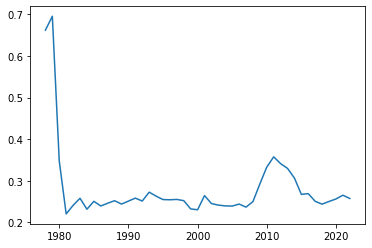

In [ ]:
# only income_change_amt_next_yr has many missing values within our chosen cts confounders

# calculate percent missing for income_change_amt_next_yr by year 
pct_missing = data['income_change_amt_next_yr'].isnull().groupby(data.date.dt.year).agg(['mean','count'])
plt.plot(pct_missing["mean"])


In [ ]:
data_xgboost, treatment_vars, confounder_vars = prep_features(data,regression=False,missing_values='imput by median')  

Excluding 15245 observations that refused or didn't know durable purchase question.
Excluding 21490 observations that did not answer price change amount question.


In [ ]:
X = data_xgboost[confounder_vars+treatment_vars]
Y = data_xgboost['durable_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/Users/drewkeller/opt/anaconda3/envs/stats/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Baseline Accuracy: %.2f%%" % (y_test.value_counts(normalize=True).max()*100))

Accuracy: 72.99%


In [ ]:
# naive model accuracy is 73.7%
y_test.value_counts(normalize=True)

2.0    0.716315
0.0    0.241569
1.0    0.042115
Name: durable_purchase, dtype: float64

In [ ]:
print('Prediction vs actual:')
pd.DataFrame({'actual': y_test, 'predicted': predictions}).groupby(['actual','predicted']).size()

Prediction vs actual:


actual  predicted
0.0     0             2569
        1                4
        2            10350
1.0     0              204
        1                1
        2             2048
2.0     0             1840
        1                4
        2            36476
dtype: int64

In [ ]:
data_xgboost[confounder_vars+treatment_vars+['durable_purchase']].corr()['durable_purchase'].sort_values()

cpi_durable_1mo_lag                    -0.159047
unemployment_next_yr_Higher            -0.134931
conditions_next_yr_Worse               -0.123850
cpi_1mo_lag                            -0.122214
unemployment_rate                      -0.119386
price_related_yr_ago_1.0               -0.111815
personal_finances_next_yr_Worse        -0.104596
zlb_1.0                                -0.096575
treatment_bins_5-10                    -0.053681
sex_Female                             -0.053163
income_quintile_Lowest                 -0.048955
treatment_bins_20+                     -0.047087
education_No high school               -0.045397
treatment_bins_10-15                   -0.042742
income_change_amt_next_yr              -0.041256
treatment_bins_15-20                   -0.037525
age                                    -0.030597
personal_finances_next_yr_Don't know   -0.026420
education_Partial high school          -0.025824
fed_funds_rate                         -0.017376
education_Missing   

## Helper Functions

In [ ]:
# Conditional outcome models (Q models)
def make_Q_model():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return xgb.XGBRegressor()

# Propensity score models (g models)
def make_g_model():
    ''' A function that returns a g model for computing propensity scores'''
    return xgb.XGBClassifier()

In [ ]:
# Functions for K-fold cross-fitting
def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    '''
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    '''

    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
        X_train = X.loc[train_index]
        A_train = A.loc[train_index]
        g = make_model()
        g.fit(X_train, A_train)

        # get predictions for split
        predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]
    
    # sanity check that overlap holds
    assert np.isnan(predictions).sum() == 0
    return predictions

def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"
    '''

    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1
    X2 = X_w_treatment.copy()
    X2["A"] = 2
    X3 = X_w_treatment.copy()
    X3["A"] = 3
    X4 = X_w_treatment.copy()
    X4["A"] = 4

    
    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        q = make_model()
        q.fit(X_train, y_train)

        if output_type =='binary':
            predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
            predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
        elif output_type == 'continuous':
            predictions0[test_index] = q.predict(X0.loc[test_index])
            predictions1[test_index] = q.predict(X1.loc[test_index])


    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

In [ ]:
# Fit single Q() model
# get conditional outcomes
Q0_lm, Q1_lm = outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, \
                                        n_splits=5, output_type="continuous")

# Fir 4 g(x) models
g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=5)